# Autoencoders Come from Artificial Neural Network

An autoencoder is a special type of neural network that copies the input values to the output values. It does not require the target variable like the conventional Y, thus it is categorized as unsupervised learning. 

Indeed, we are not so much interested in the output layer. We are interested in the hidden core layer. If the number of neurons in the hidden layers is less than that of the input layers, the hidden layers will extract the essential information of the input values.

Indeed, we are not so much interested in the output layer. We are interested in the hidden core layer. If the number of neurons in the hidden layers is less than that of the input layers, the hidden layers will extract the essential information of the input values.

If the number of neurons in the hidden layers is more than those of the input layers, the neural network will be given too much capacity to learn the data. In an extreme case, it could just simply copy the input to the output values, including noises, without extracting any essential information.

The encoding process compresses the input values to get to the core layer. The decoding process reconstructs the information to produce the outcome. The decoding process mirrors the encoding process in the number of hidden layers and neurons. Most practitioners just adopt this symmetry.

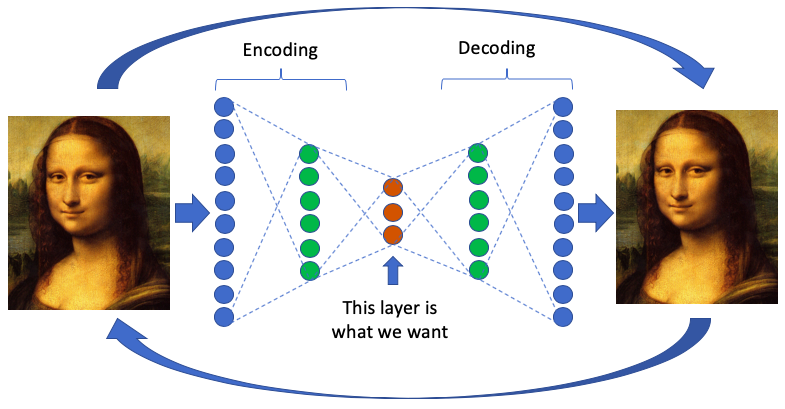

# Why Do We Apply Dimensionality Reduction to Find Outliers?

once the main patterns are identified, the outliers are revealed. Many distance-based techniques (e.g. KNNs) suffer the curse of dimensionality when they compute distances of every data point in the full feature space. High dimensionality has to be reduced. Interestingly, during the process of dimensionality reduction outliers are identified. We can say outlier detection is a by-product of dimension reduction.

# Why Autoencoders?

PCA uses linear algebra to transform.

the autoencoder techniques can perform non-linear transformations with their non-linear activation function and multiple layers. It is more efficient to train several layers with an autoencoder, rather than training one huge transformation with PCA. 
The autoencoder techniques thus show their merits when the data problems are complex and non-linear in nature.

# Build the Model

Recall that in an autoencoder model the number of the neurons of the input and output layers corresponds to the number of variables, and the number of neurons of the hidden layers is always less than that of the outside layers. 

## Library

In [16]:
import numpy as np
import pandas as pd
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import generate_data
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
%matplotlib notebook

## generate dataset

In [2]:
contamination = 0.1  # percentage of outliers
n_train = 500  # number of training points
n_test = 500  # number of testing points
n_features = 25 # Number of features

X_train, y_train, X_test, y_test = generate_data(
    n_train=n_train, n_test=n_test,
    n_features= n_features,
    contamination=contamination,random_state=1234)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

E:\programs\python\lib\site-packages\pyod\utils\data.py:190: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.8.0. Please use behaviour="new", which makes the returned datasets in the order of X_train, X_test, y_train, y_test.
  FutureWarning)


## standardize the predictors

In [3]:
X_train = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_test)

## PCA reduce to two dimensions and plot 

<IPython.core.display.Javascript object>


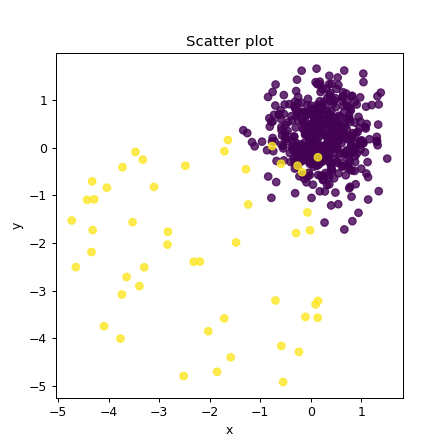

In [4]:
pca = PCA(2)
x_pca = pca.fit_transform(X_train)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']

# Plot
fig = plt.subplots( figsize=(5, 5))
plt.scatter(X_train[0], X_train[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Model specification

build three plain-vanilla models with different number of layers:

Model 1: [25, 2, 2, 25]. The input layer and the output layer has 25 neurons each. There are two hidden layers, each has two neurons.

Model 2: [25, 10, 2, 10, 25]. Besides the input layer and output layers, there are three hidden layers with 10, 2, and 10 neurons respectively.

Model 3: [25, 15, 10, 2, 10, 15, 25]. There are five hidden layers with 15, 10, 2, 10, 15 neurons respectively.

## Model 1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                650       
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 5

<IPython.core.display.Javascript object>


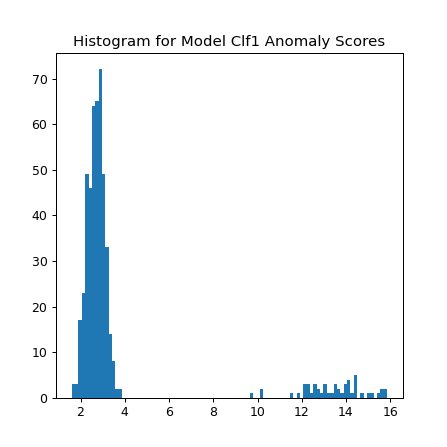

In [5]:
clf1 = AutoEncoder(hidden_neurons =[25, 2, 2, 25])
clf1.fit(X_train)

#Determine the Cut Point
# define an outlier? An outlier is a point that is distant from other points, 
# so the outlier score is defined by distance. 
# The PyOD function .decision_function() calculates the distance or 
# the anomaly score for each data point.

# Get the outlier scores for the train data
y_train_scores = clf1.decision_scores_  

# Predict the anomaly scores
y_test_scores = clf1.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

# Plot it!
fig = plt.subplots( figsize=(5, 5))
plt.hist(y_test_scores, bins='auto')  
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

If we use a histogram to count the frequency by the anomaly score, we will see the high scores corresponds to low frequency — the evidence of outliers. We choose 4.0 to be the cut point and those >=4.0 to be outliers.`

## the Summary Statistics by Cluster

Let’s assign those observations with less than 4.0 anomaly scores to Cluster 0, and to Cluster 1 for those above 4.0 (see how I use np.where() in the code). I calculate the summary statistics by cluster using .groupby() . This model has identified 50 outliers.

In [6]:
df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
df_test['cluster'].value_counts()

df_test.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,score
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.248812,0.235591,0.254013,0.239429,0.239101,0.255499,0.257207,0.24438,0.248004,0.251948,...,0.247737,0.251469,0.259140,0.249625,0.235669,0.244511,0.237602,0.246901,0.249373,2.697083
1,-2.239305,-2.120321,-2.286113,-2.154863,-2.151912,-2.299489,-2.314860,-2.19942,-2.232040,-2.267535,...,-2.229637,-2.263223,-2.332263,-2.246622,-2.121021,-2.200595,-2.138417,-2.222110,-2.244355,13.408308


The following output shows the mean variable values in each cluster. The values of Cluster ‘1’ (the abnormal cluster) is quite different from those of Cluster ‘0’ (the normal cluster). The “score” values show the average distance of those observations to others. A high “score” means that observation is far away from the norm.

## Model 2

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_6 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_7 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_8 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)               

Epoch 56/100
450/450 [==============================] - 0s 173us/sample - loss: 1.1160 - val_loss: 1.2926
Epoch 57/100
450/450 [==============================] - 0s 184us/sample - loss: 1.1152 - val_loss: 1.2895
Epoch 58/100
450/450 [==============================] - 0s 187us/sample - loss: 1.1164 - val_loss: 1.2850
Epoch 59/100
450/450 [==============================] - 0s 184us/sample - loss: 1.1104 - val_loss: 1.2823
Epoch 60/100
450/450 [==============================] - 0s 184us/sample - loss: 1.1063 - val_loss: 1.2801
Epoch 61/100
450/450 [==============================] - 0s 182us/sample - loss: 1.1073 - val_loss: 1.2780
Epoch 62/100
450/450 [==============================] - 0s 189us/sample - loss: 1.1032 - val_loss: 1.2755
Epoch 63/100
450/450 [==============================] - 0s 220us/sample - loss: 1.1047 - val_loss: 1.2734
Epoch 64/100
450/450 [==============================] - 0s 200us/sample - loss: 1.1010 - val_loss: 1.2714
Epoch 65/100
450/450 [========================

<IPython.core.display.Javascript object>


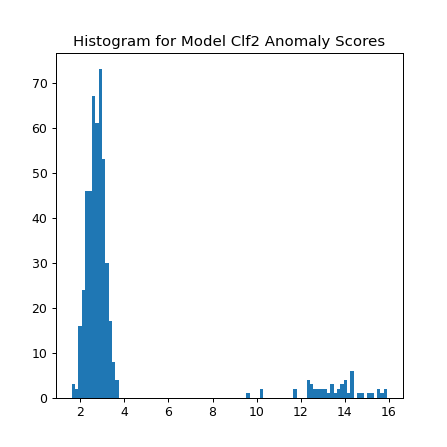

In [9]:
clf2 = AutoEncoder(hidden_neurons =[25, 10,2, 10, 25])
clf2.fit(X_train)

# Predict the anomaly scores
y_test_scores = clf2.decision_function(X_test)  
y_test_scores = pd.Series(y_test_scores)

# Plot the histogram
fig = plt.subplots( figsize=(5, 5))
plt.hist(y_test_scores, bins='auto')  
plt.title("Histogram for Model Clf2 Anomaly Scores")
plt.show()

## the Summary Statistics by Cluster

In [10]:
df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
df_test['cluster'].value_counts()
df_test.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,score
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.248812,0.235591,0.254013,0.239429,0.239101,0.255499,0.257207,0.24438,0.248004,0.251948,...,0.247737,0.251469,0.259140,0.249625,0.235669,0.244511,0.237602,0.246901,0.249373,2.719728
1,-2.239305,-2.120321,-2.286113,-2.154863,-2.151912,-2.299489,-2.314860,-2.19942,-2.232040,-2.267535,...,-2.229637,-2.263223,-2.332263,-2.246622,-2.121021,-2.200595,-2.138417,-2.222110,-2.244355,13.486114


The summary statistic of Cluster ‘1’ (the abnormal cluster) is different from those of Cluster ‘0’ (the normal cluster). The observations in Cluster 1 are outliers.

## Model 3

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_13 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_14 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_15 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 15)               

Epoch 51/100
450/450 [==============================] - 0s 209us/sample - loss: 1.1840 - val_loss: 0.7909
Epoch 52/100
450/450 [==============================] - 0s 218us/sample - loss: 1.1818 - val_loss: 0.7847
Epoch 53/100
450/450 [==============================] - 0s 227us/sample - loss: 1.1762 - val_loss: 0.7797
Epoch 54/100
450/450 [==============================] - 0s 216us/sample - loss: 1.1747 - val_loss: 0.7769
Epoch 55/100
450/450 [==============================] - 0s 218us/sample - loss: 1.1703 - val_loss: 0.7745
Epoch 56/100
450/450 [==============================] - 0s 220us/sample - loss: 1.1648 - val_loss: 0.7715
Epoch 57/100
450/450 [==============================] - 0s 211us/sample - loss: 1.1652 - val_loss: 0.7717
Epoch 58/100
450/450 [==============================] - 0s 222us/sample - loss: 1.1619 - val_loss: 0.7682
Epoch 59/100
450/450 [==============================] - 0s 256us/sample - loss: 1.1639 - val_loss: 0.7652
Epoch 60/100
450/450 [========================

<IPython.core.display.Javascript object>


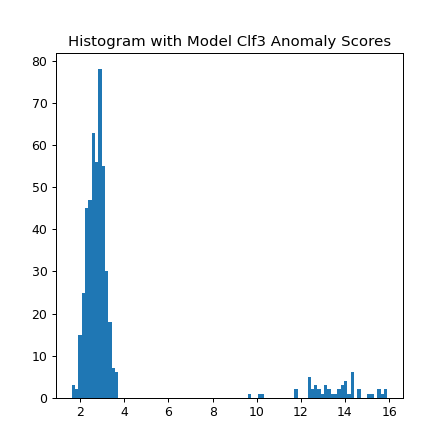

In [11]:
# Step 1: Build the model
clf3 = AutoEncoder(hidden_neurons =[25, 15, 10, 2, 10,15, 25])
clf3.fit(X_train)

# Predict the anomaly scores
y_test_scores = clf3.decision_function(X_test)  
y_test_scores = pd.Series(y_test_scores)

# Step 2: Determine the cut point
fig = plt.subplots( figsize=(5, 5))
plt.hist(y_test_scores, bins='auto')  
plt.title("Histogram with Model Clf3 Anomaly Scores")
plt.show()

## the Summary Statistics by Cluster

In [12]:
df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
df_test['cluster'].value_counts()

# Step 3: Get the summary statistics by cluster
df_test.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,score
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.248812,0.235591,0.254013,0.239429,0.239101,0.255499,0.257207,0.24438,0.248004,0.251948,...,0.247737,0.251469,0.259140,0.249625,0.235669,0.244511,0.237602,0.246901,0.249373,2.722468
1,-2.239305,-2.120321,-2.286113,-2.154863,-2.151912,-2.299489,-2.314860,-2.19942,-2.232040,-2.267535,...,-2.229637,-2.263223,-2.332263,-2.246622,-2.121021,-2.200595,-2.138417,-2.222110,-2.244355,13.478232


# Aggregate to Achieve Model Stability

Although unsupervised techniques are powerful in detecting outliers, they are prone to overfitting and unstable results. The solution is to train multiple models then aggregate the scores. 

There are four methods to aggregate the outcome as below.

   Average: average scores of all detectors.
   Maximum of Maximum (MOM)
   Average of Maximum (AOM)
   Maximum of Average (MOA)

In [14]:
# Put all the predictions in a data frame
train_scores = pd.DataFrame({'clf1': clf1.decision_scores_,
                             'clf2': clf2.decision_scores_,
                             'clf3': clf3.decision_scores_
                            })

test_scores  = pd.DataFrame({'clf1': clf1.decision_function(X_test),
                             'clf2': clf2.decision_function(X_test),
                             'clf3': clf3.decision_function(X_test) 
                            })

In [17]:
# Although we did standardization before, it was for the variables.
# Now we do the standardization for the decision scores
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

## Average Method

The average() function computes the average of the outlier scores from multiple models

<IPython.core.display.Javascript object>


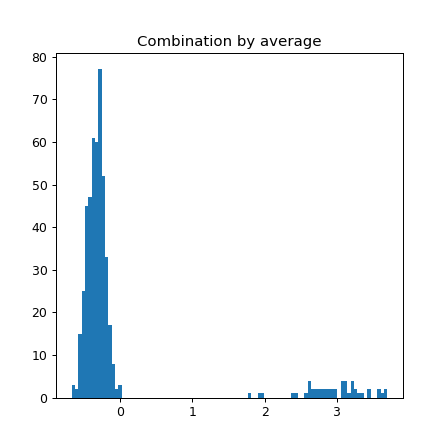

In [19]:
# Combination by average
y_by_average = average(test_scores_norm)
             
fig = plt.subplots( figsize=(5, 5))
plt.hist(y_by_average, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

It appears we can identify those >=0.0 as the outliers. 

In [20]:
df_test = pd.DataFrame(X_test)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<0, 0, 1)
df_test['y_by_average_cluster'].value_counts()

0    450
1     50
Name: y_by_average_cluster, dtype: int64

In [23]:
df_test.groupby('y_by_average_cluster').mean()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,y_by_average_score
y_by_average_cluster,,,,,,,,,,,,,,,,,,,,,
0,0.248812,0.235591,0.254013,0.239429,0.239101,0.255499,0.257207,0.24438,0.248004,0.251948,...,0.247737,0.251469,0.259140,0.249625,0.235669,0.244511,0.237602,0.246901,0.249373,-0.325626
1,-2.239305,-2.120321,-2.286113,-2.154863,-2.151912,-2.299489,-2.314860,-2.19942,-2.232040,-2.267535,...,-2.229637,-2.263223,-2.332263,-2.246622,-2.121021,-2.200595,-2.138417,-2.222110,-2.244355,2.950611


## Maximum of Maximum Method

Get the outlier scores from multiple models by taking the maximum.

<IPython.core.display.Javascript object>


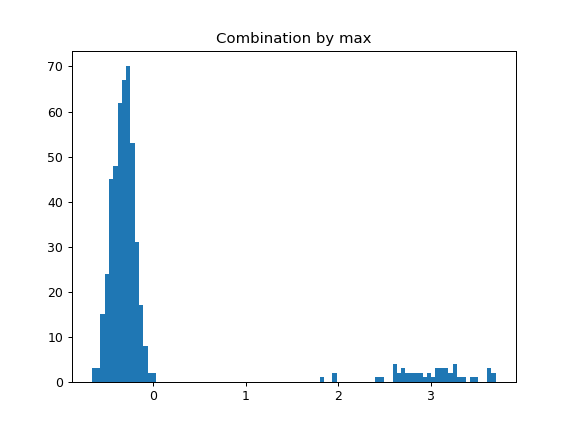

In [24]:
# Combination by max
y_by_maximization = maximization(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

In [25]:
df_test = pd.DataFrame(X_test)
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']<0, 0, 1)
df_test['y_by_maximization_cluster'].value_counts()

0    449
1     51
Name: y_by_maximization_cluster, dtype: int64

In [26]:
df_test.groupby('y_by_maximization_cluster').mean()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,y_by_average_score,y_by_average_cluster,y_by_maximization_score
y_by_maximization_cluster,,,,,,,,,,,,,,,,,,,,,
0,0.250641,0.234265,0.256385,0.238049,0.240912,0.253722,0.259439,0.243287,0.247594,0.250054,...,0.260433,0.251001,0.235403,0.245304,0.236136,0.244595,0.249588,-0.326327,0.000000,-0.323563
1,-2.206620,-2.062450,-2.257193,-2.095767,-2.120973,-2.233748,-2.284082,-2.141877,-2.179802,-2.201453,...,-2.292833,-2.209791,-2.072466,-2.159639,-2.078922,-2.153399,-2.197357,2.892540,0.980392,2.910850
